# 20. Ads Analysis

## Goal

Maybe the first industry to heavily rely on data science was the online ads industry. Data Science is used to choose which ads to show, how much to pay, optimize the ad text and the position as well as in countless of other related applications.
Optimizing ads is one of the most intellectually challenging jobs a data scientist can do. It is a really complex problem given the huge (really really huge) size of the datasets as well as number of features that can be used. Moreover, companies often spend huge amounts of money in ads and a small ad optimization improvement can be worth millions of dollars for the company.
The goal of this project is to look at a few ad campaigns and analyze their current performance as well as predict their future performance.

## Challenge Description

Company XYZ is a food delivery company. Like pretty much any other site, in order to get customers, they have been relying significantly on online ads, such as those you see on Google or Facebook.
At the moment, they are running 40 different ad campaigns and want you to help them understand their performance.
Specifically, you are asked to:
* If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.
* For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).
* Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

## Data (ad_table.csv)

Columns:
* date : all data are aggregated by date
* shown : the number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it
* clicked : the number of clicks on the ads. This is what companies pay for. By clicking on the ad, the user is brought to the site
* converted : the number of conversions on the site coming from ads. To be counted, a conversion has to happen on the same day as the ad click.
* avg_cost_per_click : on an average, how much it cost each of those clicks total_revenue : how much revenue came from the conversions
* ad : we have several different ad groups. This shows which ad group we are considering

# Solution

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.linalg as slin
from sklearn.linear_model import LinearRegression

In [2]:
ad_table = pd.read_csv('ad_table.csv')

In [3]:
# Explore data types
ad_table.info() 
# Rename columns
ad_table.rename(columns={'avg_cost_per_click': 'cost', 'total_revenue': 'revenue'}, inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 7 columns):
date                  2115 non-null object
shown                 2115 non-null int64
clicked               2115 non-null int64
converted             2115 non-null int64
avg_cost_per_click    2115 non-null float64
total_revenue         2115 non-null float64
ad                    2115 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 115.7+ KB


In [4]:
ad_table.describe()

,shown,clicked,converted,cost,revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


A few quick observations:

1. The average click-through-rate (CTR) is 4.5%, a way higher than the industry average rate.(The average click-through rate on Facebook in Food&Drink industry is 1.2%, higher than the overall indsutry rate 0.89%)
2. The average cost per click (CPC) is 1.37 dollar, higher than the industry average cost (The average click-through rate on Facebook in Food&Drink industry is 0.42 dollar, higher than the overall indsutry rate 1.68)
3. The average conversion-rate (CVR) is 4.14%, higher than the industry average (The average click-through rate on Facebook in Food&Drink industry is 3.98%, lower than the overall indsutry rate 9.11%)
4. There are some abnormal zero values
5. The sample sizes 2115, which means that there is missing value.

(Source: https://www.wordstream.com/blog/ws/2019/11/12/facebook-ad-benchmarks; 

https://www.wordstream.com/blog/ws/2019/04/01/shopping-ads-benchmarks)

### Manipulating data

1. Explore and fill missing value

In [5]:
ad_table.groupby('ad').count() ## ad_group_10, ad_group_14, ad_group_18, ad_group_20, ad_group_24 have missing data

,date,shown,clicked,converted,cost,revenue
ad,,,,,,
ad_group_1,53,53,53,53,53,53
ad_group_10,52,52,52,52,52,52
ad_group_11,53,53,53,53,53,53
ad_group_12,53,53,53,53,53,53
ad_group_13,53,53,53,53,53,53
ad_group_14,52,52,52,52,52,52
ad_group_15,53,53,53,53,53,53
ad_group_16,53,53,53,53,53,53
ad_group_17,53,53,53,53,53,53


In [6]:
ad_table.loc[ad_table['ad']=='ad_group_10'] ## missing 2015-11-04
ad_table.loc[ad_table['ad']=='ad_group_14'] ## missing 2015-11-04
ad_table.loc[ad_table['ad']=='ad_group_18'] ## missing 2015-10-09
ad_table.loc[ad_table['ad']=='ad_group_20'] ## missing 2015-11-18
ad_table.loc[ad_table['ad']=='ad_group_24'] ## missing 2015-10-03

,date,shown,clicked,converted,cost,revenue,ad
1215,2015-10-01,30984,325,3,4.19,61.55,ad_group_24
1216,2015-10-02,33878,329,3,2.99,43.88,ad_group_24
1217,2015-10-04,32998,296,3,3.10,27.58,ad_group_24
1218,2015-10-05,32116,292,3,2.79,72.21,ad_group_24
1219,2015-10-06,32915,369,3,3.07,66.41,ad_group_24
1220,2015-10-07,31613,332,3,3.40,57.46,ad_group_24
1221,2015-10-08,33531,332,3,3.34,52.25,ad_group_24
1222,2015-10-09,36209,359,3,3.76,63.61,ad_group_24
1223,2015-10-10,33312,301,3,3.38,33.91,ad_group_24
1224,2015-10-11,34654,313,3,3.07,44.94,ad_group_24


The number of the observations are 52 in ad_group_10, ad_group_14, ad_group_18, ad_group_20, ad_group_24, so that there are one missing value for each group. Let's detect group by group, and find the corresponsing missing value in each group. Group 10, group 14, group 18, group 20 and group 24 misses data in 11/04, 11/04, 10/09, 11/18, 10/03 respectively. I am going to fill the missing data with group average.

In [8]:
l = (['2015-11-04', 'ad_group_10'],['2015-11-04','ad_group_14'],['2015-10-09','ad_group_18'],
       ['2015-11-18','ad_group_20'],['2015-10-03','ad_group_24'])
for m, n in l:
    ad_table = ad_table.append({'date' : m,
                            'shown': ad_table.loc[ad_table['ad']==n,'shown'].mean(),
                            'clicked':ad_table.loc[ad_table['ad']==n,'clicked'].mean(),
                            'converted':ad_table.loc[ad_table['ad']==n,'converted'].mean(),
                            'cost':ad_table.loc[ad_table['ad']==n,'cost'].mean(),
                            'revenue':ad_table.loc[ad_table['ad']==n,'revenue'].mean(),
                            'ad':n} , ignore_index=True)
## Sort table with vale 'ad' and 'date'
ad_table=ad_table.sort_values(by=['ad','date'])

2. Explore and fill the zero values with group mean

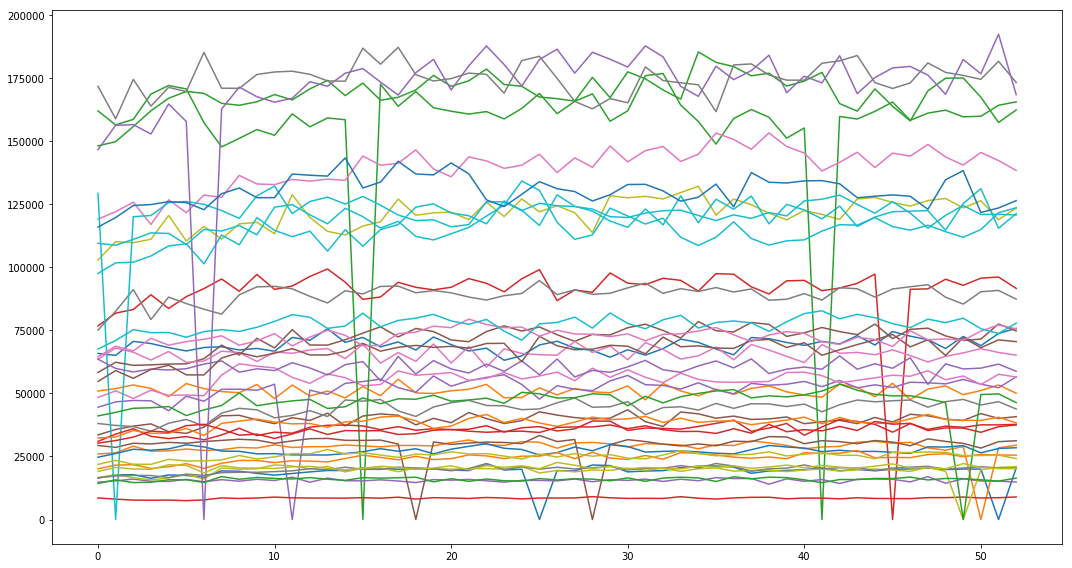

In [10]:
# visualization by group
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(1, 41):
    ad_group = 'ad_group_' + str(i)
    vals = ad_table[ad_table['ad'] == ad_group].sort_values(by='date')['shown'].values
    ax.plot(vals, label=ad_group)
# ax.legend()
plt.tight_layout()
plt.show()

Above shows trending for each group, and indicates some irregular drops to zero. I don't see those drops comes from seasonal or week-based factors, so I decided to get rid of those zeros or replaced with grouped means.

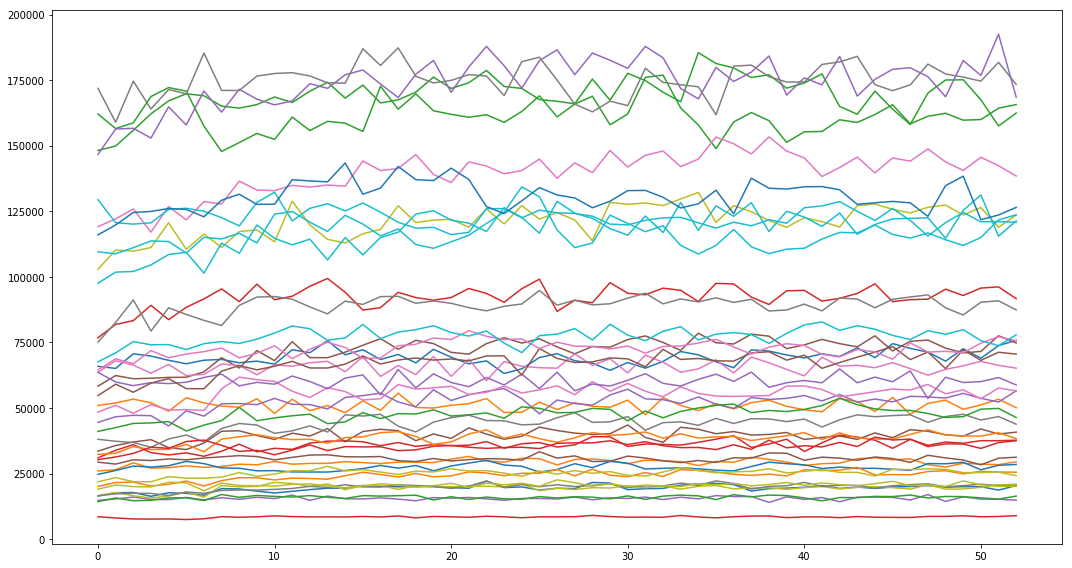

In [11]:
ad_table.loc[ad_table['shown']==0,'shown'] = ad_table.groupby("ad")['shown'].transform('mean')
ad_table.loc[ad_table['clicked']==0,'clicked'] = ad_table.groupby("ad")['clicked'].transform('mean')
ad_table.loc[ad_table['converted']==0,'converted'] = ad_table.groupby("ad")['converted'].transform('mean')
ad_table.loc[ad_table['cost']==0,'cost'] = ad_table.groupby("ad")['cost'].transform('mean')
ad_table.loc[ad_table['revenue']==0,'revenue'] = ad_table.groupby("ad")['revenue'].transform('mean')
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(1, 41):
    ad_group = 'ad_group_' + str(i)
    vals = ad_table[ad_table['ad'] == ad_group].sort_values(by='date')['shown'].values
    ax.plot(vals, label=ad_group)
# ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# Convert 'date' into datetime type
ad_table['date'] = pd.to_datetime(ad_table.date)
ad_table.to_csv('cleaned_ad_table')

## Question 1: If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

To find the 5 best ad groups, we have to decided on the metrics first. There are lots of common metrics in marketing field, such as the average CTR, the average CTC, average CVR and the profit per shown. Sustainable higher profit is our ultimate objective, and any others metrics serve for this final goal. Therefore, if we are able to calculate the profit, we definitely have to take it into account, like our case here.

In [13]:
ad_table['profit'] = ad_table['revenue'] - ad_table['cost']*ad_table['clicked']

def avg_profit_per_show(df):
    total_profit = df.profit.sum()
    total_shown = df.shown.sum()
    return total_profit / total_shown

profit_per_show_grps = ad_table.groupby("ad").apply(avg_profit_per_show).reset_index().rename(columns={0: 'unit_profit'})
profit_per_show_grps = profit_per_show_grps.sort_values(by='unit_profit', ascending= False)
profit_per_show_grps.head(5)

,ad,unit_profit
7,ad_group_16,0.020543
11,ad_group_2,0.020116
5,ad_group_14,0.016488
24,ad_group_31,0.005824
19,ad_group_27,0.000725


As the result shown, I identify group_16, group_2, group_14, group_31, and group_27.

Pros:
1. Maximizing profit is our ultimate objective
2. Higher profit sounds more convincing for shareholder

Cons:
1. Mazimizing profit in a short term may not sustainable in a long term
2. Every steps in the funnal matters.

## Question 2: For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

In [14]:
group1=ad_table.loc[ad_table['ad']=='ad_group_1']
group1.index = group1['date']

We first focus on the data from group1 and others later. For a time series data, we have to
1. detect seasonality
2. test stationarity

before run into prediction model. Those steps could help us determine which prediction model is more better.

### 1. Detect seasonality

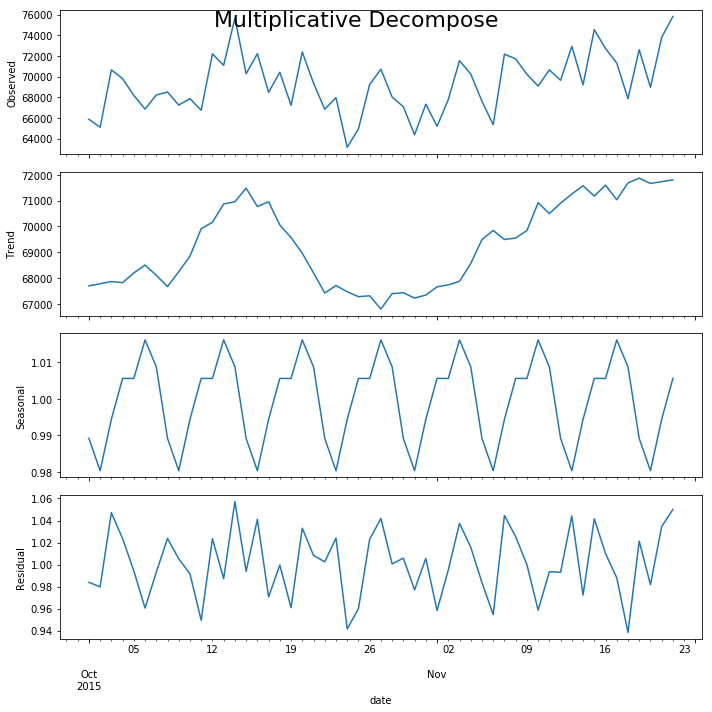

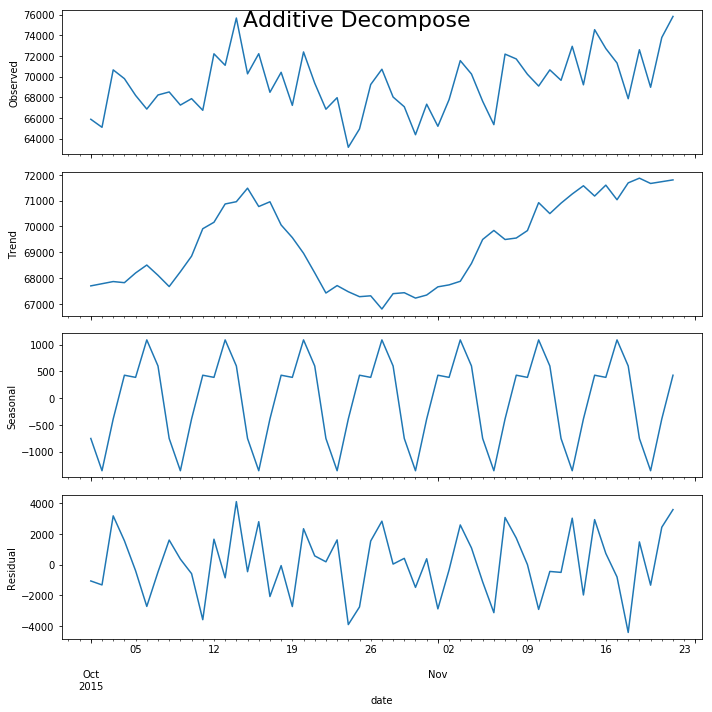

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
#from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(group1['shown'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(group1['shown'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Above decomposes the time series into its components (Trends, Seasonality, Residual), and shows obvious seasonality. The results show additive model is better as the residual very much follows random walk.

### 2. Test for stationarity

There are multiple implementations of Unit Root tests like:

1. Augmented Dickey Fuller test (ADH Test)
2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
3. Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. 

In [16]:
# ADF Test
result = sm.tsa.stattools.adfuller(group1.shown.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.45888402199822
p-value: 0.00023315943560175118
Critial Values:
   1%, -3.562878534649522
Critial Values:
   5%, -2.918973284023669
Critial Values:
   10%, -2.597393446745562


The P-Value is less than 0.05, we reject the null hypothsis and statistically believe the data is stationary and we could deploy the data without differencing or logging. 

### 3. SARIMA Model

As this data is stationary with seasonality, we are going to use SARIMA model. 

In [17]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [154]:
AIC = pd.DataFrame(columns=['Param','Seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(group1.shown,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            AIC=AIC.append({'Param': param, 'Seasonal': param_seasonal, 'AIC': results.aic},ignore_index=True)
        except: 
            continue 
AIC.loc[AIC['AIC']==min(AIC['AIC'])]

,Param,Seasonal,AIC
59,"(1, 1, 1)","(0, 1, 1, 7)",694.398615


 According Perterson, T.(2014) the AIC(Akaike information criterion) estimates the quality of each model, relative to each of the other models. The low AIC value the better. Our output suggests that SARIMA(1,1,1)x(0, 1, 1, 7) with AIC value of 694.40 is the best combination, so we should consider this to be optimal option.

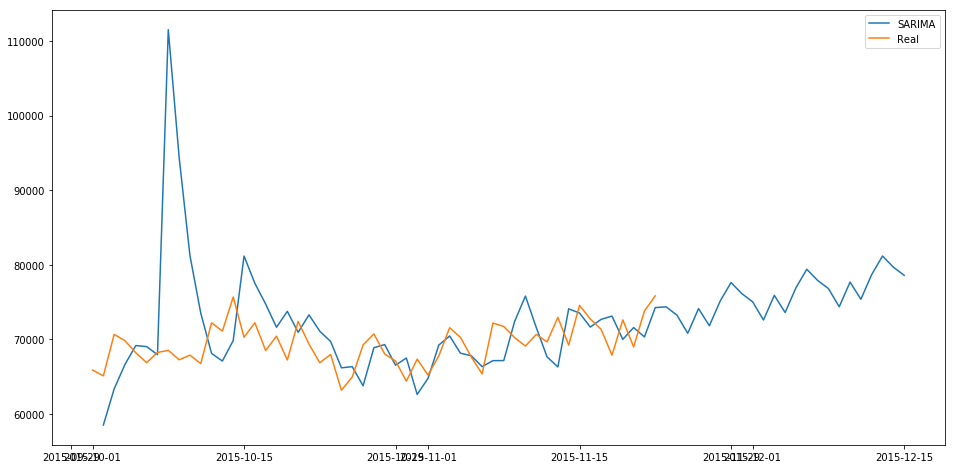

78583


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMA example
#from random import random
# fit model

model = SARIMAX(group1.shown, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7),enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=False)

# make prediction
yhat = model_fit.predict(start='2015-10-02', end = '2015-12-15')
plt.figure(figsize=(16,8))
plt.plot(yhat, label='SARIMA')
plt.plot(group1.shown, label='Real')
plt.legend(loc='best')
plt.show()
print(int(yhat[-1]))


If group1 follow the same trend over time, the number of the shown ads are 78583 in Dec 15. Then I repeat previous steps for all the other groups and predict their the number of the shown ads in Dec 15. 

In [125]:
def mod(ad_group):
    AIC = pd.DataFrame(columns=['Param','Seasonal','AIC'])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(ad_group.shown,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = mod.fit()
                AIC=AIC.append({'Param': param, 'Seasonal': param_seasonal, 'AIC': results.aic},ignore_index=True)
            except: 
                continue 
    a=list(AIC.loc[AIC['AIC']==min(AIC['AIC']),'Param'])
    b=list(AIC.loc[AIC['AIC']==min(AIC['AIC']),'Seasonal'])
    return a, b

In [124]:
def prediction(ad_group):
    for a1, a2, a3 in mod(ad_group)[0]:
        for b1, b2, b3, b4 in mod(ad_group)[1]:
            model = SARIMAX(ad_group.shown, order=(a1, a2, a3), 
                            seasonal_order=(b1, b2, b3, b4),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp= True)
        yhat = model_fit.predict(len(ad_group)+22, len(ad_group)+22)
        return int(yhat)

shown_predict=pd.DataFrame(columns=['ad','shown_Dec_15'])
for i in range(1,41):
    group_num = 'ad_group_'+str(i)
    ad_group=ad_table.loc[ad_table['ad']==group_num]
    ad_group.index=ad_group.date
    shown_predict.loc[i,'ad']=group_num
    shown_predict.loc[i,'shown_Dec_15']=prediction(ad_group)
shown_predict

,ad,shown_Dec_15
1,ad_group_1,78583
2,ad_group_2,50353
3,ad_group_3,150621
4,ad_group_4,94729
5,ad_group_5,60431
6,ad_group_6,42091
7,ad_group_7,57433
8,ad_group_8,44692
9,ad_group_9,119630
10,ad_group_10,119873


In [126]:
shown_predict.to_csv('shown_dec_15')

For each group, the prediction is shown.

### Question 3: Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

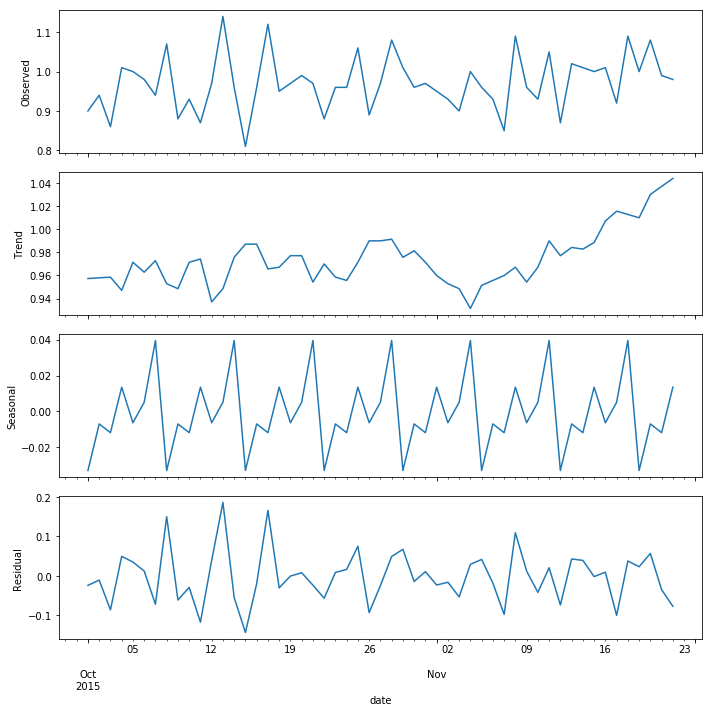

In [157]:
# Additive Decomposition
#Setting extrapolate_trend='freq' 
## takes care of any missing values in the trend and residuals at the beginning of the series.
result_add = seasonal_decompose(group1['cost'], model='additive', extrapolate_trend='freq').plot()

0.9508496983699138


Text(0.5, 0, 'Date')

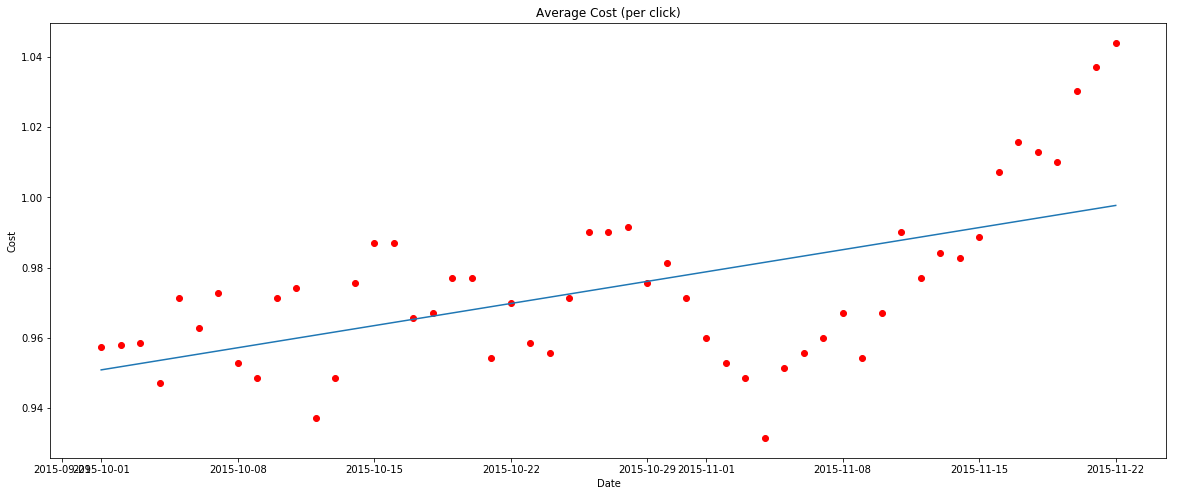

In [128]:
trend=pd.DataFrame(result_add.trend)
y_values = trend['cost']
x_values = np.linspace(0,1,len(trend))
poly_degree = 1

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
print(coeffs[1])

plt.figure(figsize=(20,8))
plt.plot(trend.index, trend["cost"], "ro")
plt.plot(trend.index,y_hat)
plt.title('Average Cost (per click)')
plt.ylabel('Cost')
plt.xlabel('Date')
#plt.savefig("NDVI_plot.png")

Take group1 as example, I get trend after removing the seasonality and residuals. Then we fit the trend with linear line. The reason why we choice linear line is that we only culster groups based on whether their cost are going up or going down. Therefore, linear line is the first model come to my mind.

In [129]:
def trend(ad_group):
    result_add = seasonal_decompose(ad_group['cost'], model='additive', extrapolate_trend='freq')
    trend=pd.DataFrame(result_add.trend)
    y_values = trend['cost']
    x_values = np.linspace(0,1,len(trend))
    poly_degree = 1
    coeffs = np.polyfit(x_values, y_values, poly_degree)
    return coeffs[0]

cost_trend=pd.DataFrame(columns=['ad','trend'])
for i in range(1,41):
    group_num = 'ad_group_'+str(i)
    ad_group=ad_table.loc[ad_table['ad']==group_num]
    ad_group.index=ad_group.date
    cost_trend.loc[i,'ad']=group_num
    cost_trend.loc[i,'trend']=trend(ad_group)

cost_trend.loc[cost_trend['trend']>0.01,'group']='up'
cost_trend.loc[cost_trend['trend'].abs()<=0.01,'group']='flat'
cost_trend.loc[cost_trend['trend']<-0.01,'group']='up'
cost_trend

,ad,trend,group
1,ad_group_1,0.0468566,up
2,ad_group_2,-0.00190305,flat
3,ad_group_3,0.0976182,up
4,ad_group_4,0.0849242,up
5,ad_group_5,-0.0315471,up
6,ad_group_6,-0.0935331,up
7,ad_group_7,-0.197084,up
8,ad_group_8,-0.138684,up
9,ad_group_9,0.0052043,flat
10,ad_group_10,-0.0187901,up


In [158]:
cost_trend.to_csv('cluster groups based on cost trending.csv')

Next, I fit linear regressions to each group. If slope absolutely values less than 0.01, one group would be perceived as flat while if higher than 0.01 or lower than -0.01, perceived as up or down.